# Miniature/spontaneous postsynaptic currents
Recording and analyzing miniature/spontaneous postsynaptic currents (m/sPSCs) is one of the most common experiments in patch clamp electrophysiology. m/sPSCs are ionic currents from AMPA, NMDA, glycine, or GABAA receptors that are evoked due to release of a single or multiple synaptic vesicles. We will cover both mPSCs and sPSCs, and go over how to analyze PSC events. While this chapter focuses on PSCs, most of the theory applies to miniature/spontaneous postsynaptic potentials (PSPs) as well. There are several experiments you can do that utilize PSCs; synapse number, silent synapses, excitatory/inhibitory ratio, synaptic multiplicity, and changes in synaptic release regulated by other non-ionic receptors.

Postsynaptic currents have a very specific shape. This shape can modeled by multiply two exponentials of opposite direction together. This shape allows PSCs to act as coincidence detectors. The sharp rise allows PSCs to be temporally precise. The long decay allows PSCs to overlap in time and summate to drive an action potential. The shorter the decay the shorter the time window PSCs have to summate. Different cells and different PSC types have different rise rates and decay rates.

## Miniature postsynaptic currents
Miniature postsynaptic currents (mPSCs) are ionic currents evoked from the release of a single synaptic vesicle {cite}`del_castillo_quantal_1954`. Frequency of mPSCs is used as a proxy for the number of functional synapses (synapses that have presynaptic input) that contain the receptor of interest (but not necessarily the number of synapses). The interpretation of mPSC data depends on what receptor you are recording from. If you are recording mEPSCs from AMPARs then you are likely getting the number of "active" or "non-silent" synapses. If you are recording NMDARs could be looking at the number of silent synapses (only if you compare to the AMPAR mEPSCs). If you are recording mIPSCs then you are getting the number of inhibitory synapses. With mIPSCs you could be getting GABAAR or GlyR. One important caveat of mPSCs is that you are not getting where the presynaptic input is coming from. If you want projection specific synaptic input you need to run a different type of experiment than we will be covering here, but is covered later in the book.

### Internal and external solutions
You will need to block spontaneous activity including tetrodotoxin (TTX) in the bath. Preferably you would also use an internal solution that contains cesium and QX-314. For more information on internals see {doc}`./internal_solutions.ipynb`. Depending on the receptor current(s) you want to record you will need to block certain other receptors by including specific drugs in the external solutions. For more information on externals see {doc}`./external_solutions.ipynb`.

### How should you record mPSCs
mPSCs are currents which means you are recording in voltage-clamp mode. This means that the amplifier will injecct current into the cell to keep it at your choosen holding voltage. Any changes in current means that the cells had a change in voltage that the amplifier is counter acting

There are two primary ways you can record mPSCs. One way is you can record continuously for about 3-5 minutes. Technically speaking this is the easiest method since you have a single recording and pretty much any simple recording software will implement this method. The second way is you can record 20-40 sweeps/acquisitions of 5-15 seconds each. Each of these acquisitions act as a kind of technical replicate. This method allows you to discard bad portions of the recording. Usually when you get proficient at patching you will rarely have bad recordings however sometimes you get 30 seconds where there is an unstable seal, digital cell phone noise, your bath gets too low, you get pump/vacuum noise or other issues. When this happens it is fine to discard the 5 or so acquisitions that are bad. You can create acquisitions from continuous recordings by splitting to get the same benefits of the sweeps/acquisitions method.

Filtering and sample rate are the other important consideration for capturing mPSCs. You generally want the sample rate to be 3-4x greater than the filter cutoff you are using with the filter cutoff determining the high frequency you are interested in. While signal theory says you have to have the sample rate 2x greater than the high frequency you are interested in, generally to capture that high frequency well you need to sample 3-4x times that rate. In general mPSCs are recorded at a 10000 Hz with a 3000 Hz lowpass cutoff. A 10000 Hz sample rate is high enough to capture the rise of a mPSCs which are fairly quick, especially for mEPSCs on parvalbumin interneurons. 10000 Hz is also a good trade off between accuracy of the signal and digital storage space. In modern times you could realistically record at 20000 Hz with no storage space issues. I suggest a mininum sample rate of 10000 Hz.

## Spontaneous postsynaptic currents

## Analyzing miniature/spontaneous PSCs.
There are several important features of m/aPSCs that you will want to analyze. The primary feature is frequency (the number of events occuring every second). Frequency is used as a proxy for the number of synapses that contain the receptor whose currents you are recording. The more mPSCs, the more synapses. However, if there are changes in release probability you could also get a change in frequency without a change in synapse number. To determine whether there are changes in release probability you will need to run some pair-pulse experiments which are described in a later chapter. Another feature is mPSC amplitude. A larger amplitude could mean two things. Larger mPSCs could mean there are more receptors at the postsynaptic element. Alternatively, larger mPSCs could mean that you get less distal synapses due to decreased dendritic length or more synapses close to the cell body with no change in dendritic length (probably less likely to occur). Amplitude of mPSCs decreases the further from the cell body that the event occurs due to dendritic filtering. To rule out one of the interpretations you can use the mEPSC rise rate (amplitude/peak_time-baseline_start) to determine if the rise rate is changed. More distal mPSCs should have a slower rise rate due to dendritic lowpass filtering. Lastly, you can look at the tau or decay rate of the mPSC. Changes in tau are usually due to changes in receptor subunit composition. Tau is especially useful when you need to identify specific cells types. Interneurons, like parvalbumin interneurons, have a very short mPESC tau compared to pyramidal neurons. Tau can also be affected by dendritic filtering.

There are several steps to processing acquisitions to find mEPSCS.
1. Filter the acquisition
2. Convolution/deconvolution to find events
3. Clean events

First we are going to import some python packages.

In [64]:
from pathlib import Path
import json

from ipywidgets import widgets, HBox, VBox, Label, FloatSlider
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, optimize, fft

Next we are going to load the data. All the data is stored on json files. While this file type is not the most practical for storing electrophysiological data, it is the very convenient since it does not require any third party python packages.

In [7]:
path = Path().cwd() 
path = path.parents[0]/ r"data/mepsc"
paths = sorted(list(path.glob("*.json")))
exp_dict = {}
for index, p in enumerate(paths):
    with open(p, "r") as rf:
        temp = json.load(rf)
        temp["array"] = temp["array"][:100000]
        exp_dict[index+1] = temp
x_array = np.arange(len(exp_dict[1]["array"])) / 10

The first thing to do is look through your data just to see what it looks like. For reference the data in this tutorial is from a layer 5 cell in the ACC of a P16 mouse. 
- The recorded data is usually in pA, as is the case for this data.
- It can be hard to see the events, however this is a parvalbumin interneuron and has very large mEPSC events.
- The acquisition mean hovers around -40 pA. This is the amount of current injected to keep the cell at the holding voltage which in this case is -70 mV.

In [8]:
def explore_plots(index):
    plt.plot(
        x_array,
        exp_dict[index]["array"],
        label=f"Acquisition: {index}",
    )

    plt.ylabel("Current (pA)")

    plt.xlabel("Time (ms)")
    plt.legend(loc=(1.04, 0.5))


out = widgets.interact(
    explore_plots,
    index=widgets.IntSlider(
        value=0,
        min=min(exp_dict.keys()),
        max=max(exp_dict.keys()),
        step=1,
    ),
)

interactive(children=(IntSlider(value=1, description='index', max=5, min=1), Output()), _dom_classes=('widget-…

First, we will define some important features of the acquisition so that we can reuse the settings throughout the analysis. It is important to note that the all the parameters are going to be in samples. The current files were recorded at 10000 Hz so we multiply the time we want, in milliseconds, time by 10 or divide sample number by 10 to get to milliseconds.

In [9]:
baseline_start = 0
baseline_end = 3000
sample_rate = 10000

### Filter the acquisition
First thing we need to do is filter the acquisition. There are two ways to filter. You can remove the baseline then lowpass filter or you can apply a bandpass filter. Filtering achieves two goals. The first is remove the DC offset. The DC offset is actually the current need to clamp the voltage. The second goal is to remove extraneous high frequency noise which can hinder the analysis. You can also use notch filter to remove 60 Hz, however I recommend finding ways to reduce 60 Hz before you even record. Notch filters can introduce artifacts into and distort your signal.

For this tutorial we will use remove the baseline by taking the mean and use a zero-phase Butterworth filter with an order 4 filter and a lowpass cutoff of 600 Hz and compare that to a bandpass cutoff of [0.01, 600] to remove the DC offset and high frequency noise. If you want to learn more about filtering checkout the chapter on filtering. For the PSC tutorial we are going to skip the RC check.

#### Filter method 1: Remove the baseline and lowpass filter

In [34]:
for value in exp_dict.values():
    baseline = np.mean(value["array"])
    temp = value["array"] - baseline
    value["holding_current"] = baseline
    sos = signal.butter(
            4, Wn=600, btype="lowpass", output="sos", fs=sample_rate
        )
    filt_array = signal.sosfiltfilt(sos, temp)
    value["lowpass"] = filt_array

#### Filter method 2: Bandpass filter

In [35]:
for value in exp_dict.values():
    baseline = np.mean(value["array"])
    temp = value["array"] - baseline
    sos = signal.butter(
            4, Wn=[0.01, 600], btype="bandpass", output="sos", fs=sample_rate
        )
    filt_array = signal.sosfiltfilt(sos, temp)
    value["bandpass"] = filt_array

Let's compare the two types of filtering. Some things to notice.
- Both methods filter almost identically and substantially reduce the noise.
- Both methods reduce the size of the mEPSC.
- With a zero-phase filter we can prevent any phase changes so the timing of the baseline and peak of the mEPSC events is unchanged.

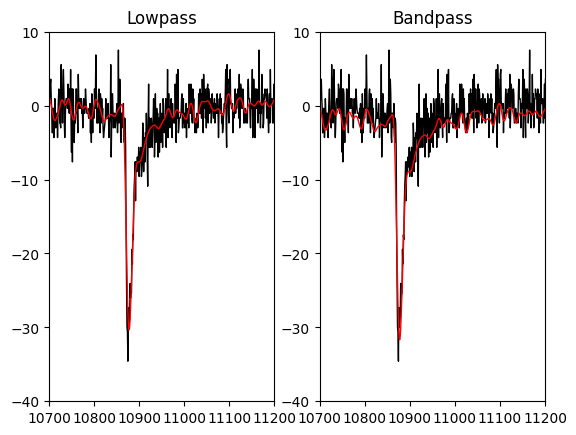

In [36]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(exp_dict[1]["array"]-exp_dict[1]["holding_current"], c="black", linewidth=1)
ax[0].plot(exp_dict[1]["lowpass"], c="red", linewidth=1)
ax[0].set_title("Lowpass")
ax[1].plot(exp_dict[1]["array"]-exp_dict[1]["holding_current"], c="black", linewidth=1)
ax[1].plot(exp_dict[1]["bandpass"], c="red", linewidth=1)
ax[1].set_title("Bandpass")
for a in ax:
    a.set_xlim(10700,11200)
    a.set_ylim(-40, 10)

### Template matching vs deconvolution
There are main two ways, template matching (correlation) and deconvolution, to identify m/sPSCs, both need a template PSC. Convolution is the "traditional" way however I have seen quite a few new papers using a deconvolution method since it is less dependent on the exact template shape. We will cover both methods to see how each works. If you want to learn more about convolution and deconvolution check out the signal processing chapter.

#### Create a template
First we are going to create a template PSC. We will use the same template for each method. The template is a double exponential with a exponential rise multiplied by an exponential decay. You can see the template equation below. 

In [44]:
def create_template(
    amplitude: int | float = -20,
    rise_tau: int | float = 0.3,
    decay_tau: int | float = 5,
    risepower: int | float = 0.5,
    length: int | float = 30,
    spacer: int | float = 1.5,
    sample_rate: int = 10000,
) -> np.ndarray:
    """Creates a template based on several factors.

    Args:
        amplitude (float): Amplitude of template
        rise_tau (float): Rise tau (ms) of template
        decay_tau (float): Decay tau (ms) of template
        risepower (float): Risepower of template
        length (float): Length of time (ms) for template
        spacer (int, optional): Delay (ms) until template starts. Defaults to 1.5.

    Returns:
        np.array: Numpy array of the template.
    """
    if rise_tau == decay_tau:
        raise ValueError("Rise tau cannot equal decay tau")
    s_r_c = sample_rate / 1000
    rise_tau = int(rise_tau * s_r_c)
    decay_tau = int(decay_tau * s_r_c)
    length = int(length * s_r_c)
    spacer = int(spacer * s_r_c)
    template = np.zeros(length + spacer)
    t_length = np.arange(0, length)
    offset = len(template) - length
    Aprime = (decay_tau / rise_tau) ** (rise_tau / (rise_tau - decay_tau))
    y = (
        amplitude
        / Aprime
        * ((1 - (np.exp(-t_length / rise_tau))) ** risepower * np.exp((-t_length / decay_tau)))
    )
    template[offset:] = y
    return template

You can see the default template that is output from the create_template function below. If you are using the notebook there is an interactive widget that allows you to change the parameters of the create_template equation.

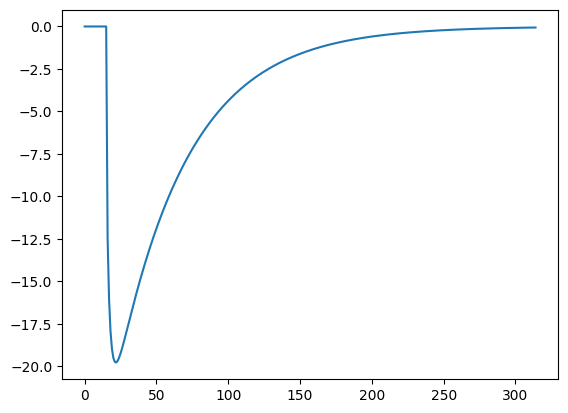

In [50]:
plt.plot(create_template())

In [ ]:
def explore_plots(amplitude=-20, rise_tau=0.3, decay_tau=5.0, risepower=0.5, length=30.0):
    template = create_template(amplitude, rise_tau, decay_tau, risepower, length)
    plt.plot(
        np.arange(len(template))/10,
        template,
    )

    plt.ylabel("Current (pA)")

    plt.xlabel("Time (ms)")

out = widgets.interact(
    explore_plots,
    amplitude = (-100, -5, 1),
    rise_tau=(0.1, 5.0, 0.1),
    decay_tau=(1.0, 10.0, 0.25),
    risepower=(0.1, 5, 0.1),
    length=(20.0, 100.0, 1.0),
    )

interactive(children=(IntSlider(value=-20, description='amplitude', max=-5, min=-100), FloatSlider(value=0.3, …

For the analysis of mEPSCs on parvalbumin interneurons we just need to modify the decay rate of the template since PV cell mEPSCs tend to have a very fast decay compared to other cell types (think about why this might be related to the function of PV cells in the larger circuit).

In [59]:
template = create_template(decay_tau=2.5)

#### Method 1: Template matching
Template matching essentially slides the template along the acquisition and correlates the template with the segment of the acquisition it is currently aligned with. I do some extract work to ensure the template matched array is zero phase relative to the original array. This makes it easier to find PSC events.

In [81]:
for value in exp_dict.values():
    temp_match = np.correlate(value["lowpass"], template, mode="full")
    half = len(value["lowpass"])//2
    mid_point = len(temp_match)//2
    temp_match = temp_match[mid_point-half:mid_point+half]
    value["temp_match"] = temp_match

#### Method 2: Deconvolution
Deconvolution essetially divides out the template from the acquisition. Deconvolution is inherently noisy so the deconvolve output has to be filtered to even see the signal.

In [82]:
for value in exp_dict.values():
    kernel = np.hstack((template, np.zeros(len(value["lowpass"]) - len(template))))
    template_fft = fft.fft(kernel)
    signal_fft = fft.fft(value["lowpass"])
    temp = signal_fft / template_fft
    temp = np.real(fft.ifft(temp))
    sos = signal.butter(
            4, Wn=300, btype="lowpass", output="sos", fs=sample_rate
        )
    deconvolved = signal.sosfiltfilt(sos, temp)
    value["deconvolved"] = deconvolved

In [ ]:
fig, ax = plt.subplots()